In [1]:
# import librosa
# import IPython.display
# import matplotlib as mpl
# import matplotlib.font_manager as fm

In [2]:
# data.zip 파일 업로드

In [3]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################
import matplotlib.pyplot as plt

########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
########################################################################

In [4]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "autoencoder.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="autoencoder.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
########################################################################

In [5]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())
# c:\workspace\autoencoder\02_autoencoder

c:\workspace\autoencoder\02_autoencoder


In [6]:
# 스크립트 실행 경로 변경
# c:\workspace\autoencoder\02_autoencoder 으로 변경
os.chdir('c:/workspace/autoencoder/02_autoencoder')

In [7]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())

c:\workspace\autoencoder\02_autoencoder


In [8]:
# 하위에 dataset 폴더가 존재하지 않으면 생성
os.makedirs('./dataset', exist_ok=True)

In [9]:
# zip file(.wav files) 압축 해제
import zipfile



In [10]:
# fantasy_zip = zipfile.ZipFile('./36cc.zip')
# fantasy_zip.extractall('./dataset/')
# fantasy_zip.close()

In [11]:
fantasy_zip = zipfile.ZipFile('./36cc_wav_files.zip')
fantasy_zip.extractall('./dataset/')
fantasy_zip.close()

In [12]:
# https://wfdb.readthedocs.io/en/latest/
# The native Python waveform-database (WFDB) package
# A library of tools for reading, writing, and processing WFDB signals and annotations.
import wfdb

In [13]:
# https://wfdb.readthedocs.io/en/latest/wfdb.html?highlight=rdrecord#wfdb.rdrecord
# Read a WFDB record and return the signal and record descriptors as attributes in a Record or MultiRecord object.
rd_record = wfdb.rdrecord('pure_0.wav')

Reading Mono formatted .wav file...
Sample rate: 44100
Byte rate: 88200
Block align: 2
Bits per sample: 16


In [14]:
# rd_record = wfdb.rdrecord(test_wav_normal_01)

In [15]:
# https://ahnjg.tistory.com/84
# librosa.load와 scipy.io.wavfile.read의 차이점
# librosa로 데이터를 읽으면 데이터의 범위가 -1 ~ 1의 범위로 정규화된다
# librosa의 입력에서 sr=None으로 지정하지 않고 임의의 sample_rate를 설정하면 load 할 때 resampling을 수행합니다.


In [16]:
test_wav_normal_01 = './dataset/36cc_wav_files/normal/36cc_OK_2208211119H0010019498_TDM_2022-03-30_15-23-56__Microphone.wav'
test_wav_abnormal_01 = './dataset/36cc_wav_files/abnormal/36cc_NO_2208212119H0010019788_TDM_2022-03-30_15-55-34__Microphone.wav'

In [17]:
import scipy.io.wavfile
scipy_sr, scipy_y = scipy.io.wavfile.read(test_wav_normal_01)
# Sample rate: 51200, Byte rate: 102400

In [18]:
print(f"scipy_sr = {scipy_sr}")
# Sample rate를 원래의 Sample rate로 가져온다.

scipy_sr = 51200


In [19]:
print(f"scipy_y.shape = {scipy_y.shape}")
# print(f"number of channels = {scipy_y.shape[1]}")

scipy_y.shape = (1369362,)


In [20]:
wavelength = scipy_y.shape[0] / scipy_sr
print(f"length = {wavelength}s")
# 16초 길이를 가지고 있다.

length = 26.7453515625s


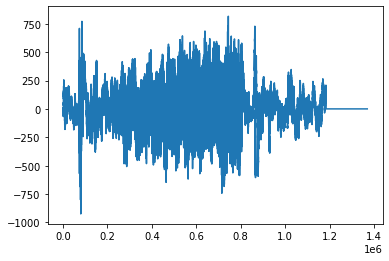

In [21]:
plt.plot(scipy_y)
# scipy로 가져오면 데이터 분포가 약 -4000 ~ 400 이다.

In [22]:
librosa_y, librosa_sr = librosa.load(test_wav_abnormal_01)

In [23]:
print('scipy_y.shape:', scipy_y.shape)
print('type(scipy_y[0]):', type(scipy_y[0]))
print('scipy_sr:', scipy_sr)
print('--------------------------------------')
print('librosa_y.shape:', librosa_y.shape)
print('type(librosa_y[0]):', type(librosa_y[0]))
print('librosa_sr:', librosa_sr)
# librosa는 Sample Rate를 지정하지 않으면 기본 sr=22050으로 지정된다.

scipy_y.shape: (1369362,)
type(scipy_y[0]): <class 'numpy.int16'>
scipy_sr: 51200
--------------------------------------
librosa_y.shape: (585105,)
type(librosa_y[0]): <class 'numpy.float32'>
librosa_sr: 22050


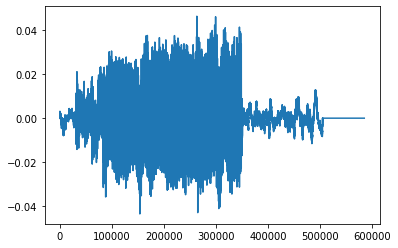

In [24]:
plt.plot(librosa_y)
# librosa는 데이터 범위가 -1~1로 정규화 된다.

C:\Users\astro\AppData\Local\Temp\ipykernel_8244\2557505744.py:6: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(librosa_y, librosa_sr)#, alpha=0.5)


Text(0.5, 1.0, 'A Normal e-compressor')

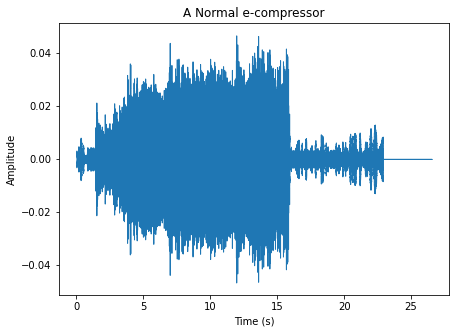

In [25]:
# https://www.dacon.io/competitions/official/235616/codeshare/1277
# https://librosa.org/doc/0.9.1/generated/librosa.display.waveshow.html#librosa.display.waveshow
# Visualize a waveform in the time domain
# y축은 진폭, x축은 시간을 나타낸다.
plt.figure(figsize=(7,5))
librosa.display.waveshow(librosa_y, librosa_sr)#, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("A Normal e-compressor")
# Amplitude: 진폭: 진동하고 있는 물체가 정지 또는 평형 위치에서 최대 변위까지 이동하는 거리. 진동하는 폭의 절반이다.

C:\Users\astro\AppData\Local\Temp\ipykernel_8244\138284715.py:5: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(librosa_y, librosa_sr)


Text(0.5, 1.0, 'A Normal e-compressor')

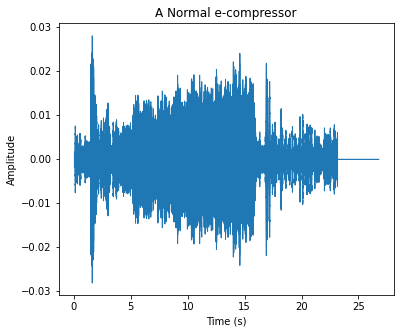

In [26]:
# <그림 8>은 1d signal 분석을 위해 정규화한 데이터를 librosa 라이브러리의 waveshow 함수를 이용해 시각화 한 결과이다.
# (왼쪽: 정상 sample, 오른쪽 비정상 sample)
librosa_y, librosa_sr = librosa.load(test_wav_normal_01)
plt.figure(figsize=(6,5))
librosa.display.waveshow(librosa_y, librosa_sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("A Normal e-compressor")

C:\Users\astro\AppData\Local\Temp\ipykernel_8244\4154785986.py:5: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(librosa_y, librosa_sr)


Text(0.5, 1.0, 'An Anomalous e-compressor')

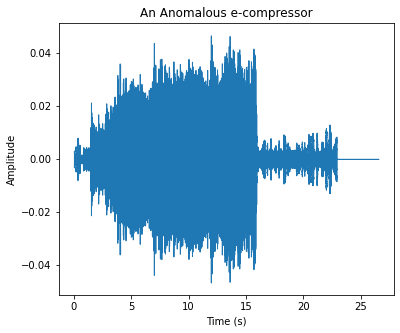

In [27]:
# <그림 8>은 1d signal 분석을 위해 정규화한 데이터를 librosa 라이브러리의 waveshow 함수를 이용해 시각화 한 결과이다.
# (왼쪽: 정상 sample, 오른쪽 비정상 sample)
librosa_y, librosa_sr = librosa.load(test_wav_abnormal_01)
plt.figure(figsize=(6,5))
librosa.display.waveshow(librosa_y, librosa_sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("An Anomalous e-compressor")

C:\Users\astro\AppData\Local\Temp\ipykernel_8244\3047828482.py:3: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y, sr)


Text(0.5, 1.0, 'librosa.display.waveshow')

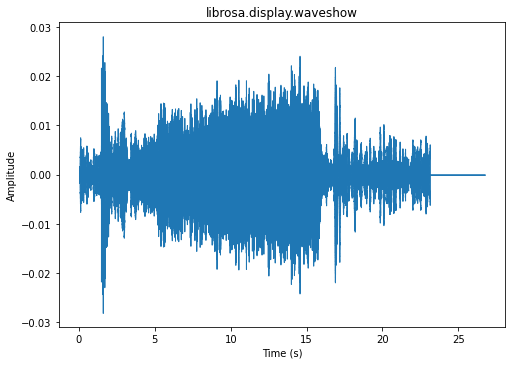

In [28]:
y, sr = librosa.load(test_wav_normal_01)
plt.figure(figsize=(8,5.6))
librosa.display.waveshow(y, sr)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("librosa.display.waveshow")

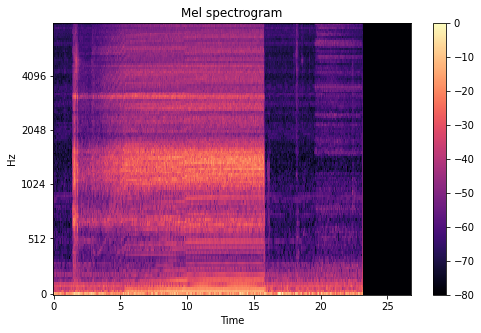

In [29]:
# Generate mfccs from a time series
y, sr = librosa.load(test_wav_normal_01)
librosa.feature.mfcc(y=y, sr=sr)

# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                   fmax=8000)
librosa.feature.mfcc(S=librosa.power_to_db(S))

# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

# Visualize the MFCC series
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(8, 5))
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax)

fig.colorbar(img, ax=[ax])
ax.set(title='Mel spectrogram')
ax.label_outer()


[Text(0.5, 1.0, 'MFCC')]

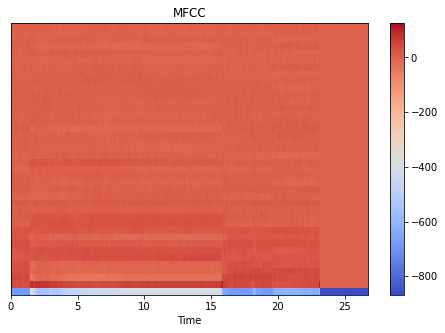

In [30]:
# Generate mfccs from a time series
y, sr = librosa.load(test_wav_normal_01)
librosa.feature.mfcc(y=y, sr=sr)

# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                   fmax=8000)
librosa.feature.mfcc(S=librosa.power_to_db(S))

# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

# Visualize the MFCC series
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, sharex=True, figsize=(8,5))
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=[ax])
ax.set(title='MFCC')

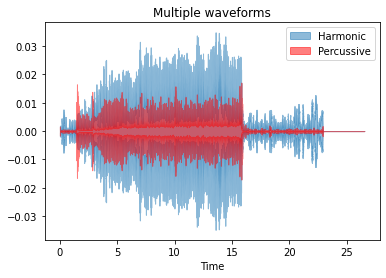

In [31]:
fig, ax = plt.subplots(nrows=1, sharex=True)
y_harm, y_perc = librosa.effects.hpss(librosa_y)
librosa.display.waveshow(y_harm, sr=librosa_sr, alpha=0.5, ax=ax, label='Harmonic')
librosa.display.waveshow(y_perc, sr=librosa_sr, color='r', alpha=0.5, ax=ax, label='Percussive')
ax.set(title='Multiple waveforms')
ax.legend()
# Harmonic: 배음: 진동체가 내는 여러 가지 소리 가운데, 원래 소리보다 큰 진동수를 가진 소리. 보통 원래 소리의 정수배(整數倍)가 되는 소리를 이른다.
# (바이올린 같은 악기의 현을 살짝 건드려 낼 수 있는) 고음
# Percussive: (특히 타악기를) 쳐서 소리를 내는
# https://jonhyuk0922.tistory.com/114
# * Harmonics : 사람의 귀로 구분할 수 없는 특징들(음악의 색깔)
# * Percussives: 리듬과 감정을 나타내는 충격파

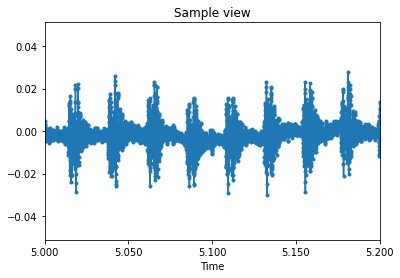

In [32]:
# https://www.dacon.io/competitions/official/235616/codeshare/1277
# https://librosa.org/doc/0.9.1/generated/librosa.display.waveshow.html#librosa.display.waveshow
fig, ax = plt.subplots(nrows=1, sharex=True)
ax.set(xlim=[5.00, 5.20], title='Sample view')#, ylim=[-0.2, 0.2])
librosa.display.waveshow(librosa_y, sr=librosa_sr, ax=ax, marker='.', label='Full signal')
ax.label_outer()
#Rax.legend()

In [33]:
import seaborn as sns

c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

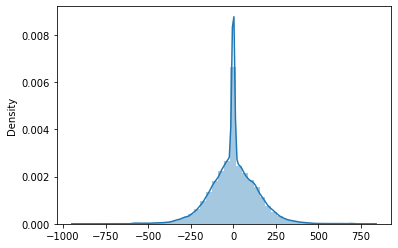

In [34]:
# scipy와 librosa로 가져온 데이터의 분포를 살펴보겠습니다.
# https://ahnjg.tistory.com/84
sns.distplot(scipy_y)

c:\Users\astro\anaconda3\envs\ae2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

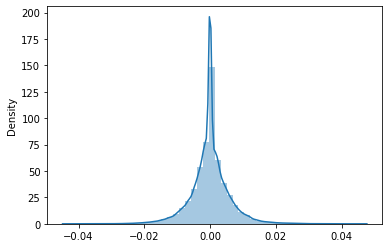

In [35]:
# librosa로 가져온 데이터는 -1 ~ 1 의 범위로 정규화 되어있다.
# liborsa 입력에서 sr=None 로 지정하지 않고 임의의 sample_rate를 설정하면 load할 때 resampling을 수행한다.
sns.distplot(librosa_y)

In [36]:
print(librosa_y.shape)
print(scipy_y.shape)

(585105,)
(1369362,)


In [37]:
import matplotlib.pyplot as plt

22050


C:\Users\astro\AppData\Local\Temp\ipykernel_8244\2825423013.py:14: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y, sr, ax=ax)


Text(30.5, 0.5, 'Abnormal')

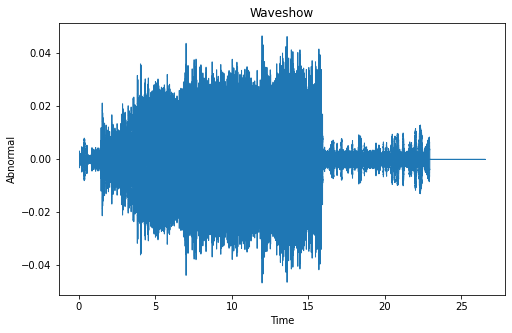

In [38]:
# amplitude: 진폭
# waveshow
# https://librosa.org/doc/latest/generated/librosa.display.waveshow.html
# Librosa 라이브러리의 load함수로 wav파일을 불러와 waveshow를 통해 소리데이터의 Time domain 파형을 시각화 합니다
# Sampling rate는 오디오에 맞게 설정할 수 있으며, 설정하지 않으면 기본값인 22050으로 불러오게 됩니다.
# 그림[1]는 waveshow함수를 통해 wav파일을 시각화 한 것이며, x축은 Time, y축은 진폭을 나타냅니다.
# https://hyongdoc.tistory.com/401?category=884319


y, sr = librosa.load(test_wav_abnormal_01)
print(sr)

fig, ax = plt.subplots(nrows=1, figsize=(8,5))
librosa.display.waveshow(y, sr, ax=ax)
ax.set(title='Waveshow')
ax.set_ylabel('Abnormal')

22050


C:\Users\astro\AppData\Local\Temp\ipykernel_8244\3018651852.py:5: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y, sr, ax=ax)


Text(24.125, 0.5, 'Amplitude')

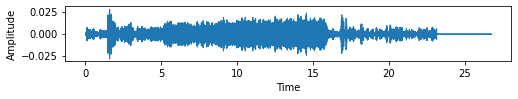

In [39]:
y, sr = librosa.load(test_wav_normal_01)
print(sr)

fig, ax = plt.subplots(nrows=1, figsize=(8,1))
librosa.display.waveshow(y, sr, ax=ax)
# ax.set(title='Waveshow')
ax.set_ylabel('Amplitude')

In [40]:
import pandas as pd

In [41]:
os.chdir('C:/workspace/autoencoder/02_autoencoder/')

In [42]:
wav_normal_path = './dataset/36cc_wav_files/normal/'
print("csv folders:", wav_normal_path)
file_list = os.listdir(wav_normal_path)
# print(file_list)

csv folders: ./dataset/36cc_wav_files/normal/


In [43]:
# import wfdb
import scipy.io.wavfile
normal_df = pd.DataFrame()

for j in tqdm(file_list, position=0, leave=True):
    wav_name = wav_normal_path+j
    # rd_record = wfdb.rdrecord(wav_name, return_fig=True)
    # wav_sr = rd_record.fs[0]
    # librosa_y, librosa_sr = librosa.load(wav_name, sr=wav_sr)
    #scipy_sr, scipy_y = scipy.io.wavfile.read(wav_name)
    librosa_y, librosa_sr = librosa.load(wav_name, sr=16000)
    data_df = pd.DataFrame(librosa_y.reshape(1,-1))
    #data_df = pd.DataFrame(scipy_y.reshape(1,-1))
    normal_df = pd.concat([normal_df, data_df])
    # print(wav_name, normal_df.shape)
print(normal_df.shape)

100%|██████████| 36/36 [00:35<00:00,  1.00it/s]

(36, 438423)


In [44]:
normal_df.shape

(36, 438423)

In [45]:
wav_normal_path = './dataset/36cc_wav_files/normal_test/'
print("csv folders:", wav_normal_path)
normal_test_file_list = os.listdir(wav_normal_path)
# print(file_list)

csv folders: ./dataset/36cc_wav_files/normal_test/


In [46]:
# import wfdb
import scipy.io.wavfile
normal_test_df = pd.DataFrame()

for j in tqdm(normal_test_file_list, position=0, leave=True):
    wav_name = wav_normal_path+j
    # rd_record = wfdb.rdrecord(wav_name, return_fig=True)
    # wav_sr = rd_record.fs[0]
    # librosa_y, librosa_sr = librosa.load(wav_name, sr=wav_sr)
    #scipy_sr, scipy_y = scipy.io.wavfile.read(wav_name)
    librosa_y, librosa_sr = librosa.load(wav_name, sr=16000)
    data_df = pd.DataFrame(librosa_y.reshape(1,-1))
    #data_df = pd.DataFrame(scipy_y.reshape(1,-1))
    normal_test_df = pd.concat([normal_test_df, data_df])
    # print(wav_name, normal_df.shape)
print(normal_test_df.shape)

100%|██████████| 2/2 [00:01<00:00,  1.05it/s]

(2, 421574)


In [47]:
normal_test_df.shape

(2, 421574)

In [48]:
wav_abnormal_path = './dataset/36cc_wav_files/abnormal/'
print("csv folders:", wav_abnormal_path)
abnormal_file_list = os.listdir(wav_abnormal_path)
print(abnormal_file_list)

csv folders: ./dataset/36cc_wav_files/abnormal/
['36cc_NO_2208211119H0010019698_TDM_2022-03-30_16-22-03__Microphone.wav', '36cc_NO_2208212119H0010019788_TDM_2022-03-30_15-55-34__Microphone.wav']


In [49]:
# import wfdb
import scipy.io.wavfile
abnormal_df = pd.DataFrame()

for j in tqdm(abnormal_file_list, position=0, leave=True):
    wav_name = wav_abnormal_path+j
    # rd_record = wfdb.rdrecord(wav_name, return_fig=True)
    # wav_sr = rd_record.fs[0]
    # librosa_y, librosa_sr = librosa.load(wav_name, sr=wav_sr)
    #scipy_sr, scipy_y = scipy.io.wavfile.read(wav_name)
    librosa_y, librosa_sr = librosa.load(wav_name, sr=16000)
    data_df = pd.DataFrame(librosa_y.reshape(1,-1))
    #data_df = pd.DataFrame(scipy_y.reshape(1,-1))
    abnormal_df = pd.concat([abnormal_df, data_df])
    # print(wav_name, abnormal_df.shape)
print(abnormal_df.shape)    

100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

(2, 424726)


In [50]:
abnormal_df

,0,1,2,3,4,5,6,7,8,9,...,424716,424717,424718,424719,424720,424721,424722,424723,424724,424725
0,0.000984,0.001329,0.001222,0.001454,0.001142,0.001349,0.001189,0.001264,0.001346,0.001341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.001843,0.003097,0.002551,0.002861,0.002792,0.002615,0.002630,0.002607,0.002583,0.002497,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# Abnormal + normal 합치기
df = pd.DataFrame()
df = pd.concat([df, normal_df])
df = pd.concat([df, normal_test_df])
df = pd.concat([df, abnormal_df])

In [52]:
df.shape

(40, 438423)

In [53]:
# raw_data0 = df.values
# raw_data0 = raw_data0.astype('float32') / 255.
# df = pd.DataFrame(raw_data0)

In [54]:
print(type(df))
print(df.shape)
last_column = df.shape[1]
print(last_column)

<class 'pandas.core.frame.DataFrame'>
(40, 438423)
438423


In [55]:
# Null 제거 위해 null 확인
# df.isna().sum()
# df.isnull().sum()
df.isin([np.nan,np.inf]).sum()

0          0
1          0
2          0
3          0
4          0
          ..
438418    39
438419    39
438420    39
438421    39
438422    39
Length: 438423, dtype: int64

In [56]:
# Null 제거
df = df.dropna(axis=1)

In [57]:
df.shape

(40, 404853)

In [58]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,404843,404844,404845,404846,404847,404848,404849,404850,404851,404852
0,-0.000929,-0.001677,-0.001346,-0.001601,-0.001279,-0.001557,-0.001323,-0.001306,-0.001357,-0.001346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.003716,0.006206,0.005387,0.005922,0.005639,0.005819,0.005612,0.005743,0.005605,0.005658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.001630,0.002783,0.002351,0.002602,0.002535,0.002590,0.002668,0.003034,0.002848,0.002828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.000572,0.001148,0.000977,0.000989,0.000890,0.000998,0.000930,0.001095,0.000900,0.000806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.000376,0.000673,0.000604,0.000593,0.000535,0.000612,0.000468,0.000425,0.000583,0.000352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
label = ['1','1','1','1','1','1','1','1','1','1'\
        ,'1','1','1','1','1','1','1','1','1','1'\
        ,'1','1','1','1','1','1','1','1','1','1'\
        ,'1','1','1','1','1','1','1','1','0','0']
print(label)

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0']


In [60]:
df[last_column] = label

In [61]:
df.shape

(40, 404854)

In [62]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,404844,404845,404846,404847,404848,404849,404850,404851,404852,438423
0,-0.000929,-0.001677,-0.001346,-0.001601,-0.001279,-0.001557,-0.001323,-0.001306,-0.001357,-0.001346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,0.003716,0.006206,0.005387,0.005922,0.005639,0.005819,0.005612,0.005743,0.005605,0.005658,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,0.001630,0.002783,0.002351,0.002602,0.002535,0.002590,0.002668,0.003034,0.002848,0.002828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,0.000572,0.001148,0.000977,0.000989,0.000890,0.000998,0.000930,0.001095,0.000900,0.000806,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0,0.000376,0.000673,0.000604,0.000593,0.000535,0.000612,0.000468,0.000425,0.000583,0.000352,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [63]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [64]:
dataframe = df
raw_data = dataframe.values

# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data[:36, :], labels[:36], test_size=0.05, random_state=2
)

normal_test_ok = data[36:38, :]
normal_test_nok = data[38:, :]

In [65]:
print(data[:36, :].shape)
print(data[36:38, :].shape)
print(data[38:, :].shape)
print(labels[:36])
print(labels[36:38])
print(labels[38:])


(36, 404853)
(2, 404853)
(2, 404853)
['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
['1' '1']
['0' '0']


In [66]:
print(train_labels.shape)
print(test_labels.shape)

(34,)
(2,)


In [67]:
# DataFrame.head(n=5): Parameters ==> nint, default 5
print(type(dataframe.head()))
# <class 'pandas.core.frame.DataFrame'>
print(dataframe.head().shape)
# (5, 141)

<class 'pandas.core.frame.DataFrame'>
(5, 404854)


In [68]:
print(raw_data.shape)
# (4998, 141)
print(raw_data[:, -1].shape)
# (4998,)

(40, 404854)
(40,)


In [69]:
labels

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0',
       '0'], dtype=object)

In [70]:
train_labels

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1'], dtype=object)

In [71]:
test_labels

array(['1', '1'], dtype=object)

In [72]:
# # The last element contains the labels # 마지막 열
# labels = raw_data[:, -1]

# print(type(labels))
# # <class 'numpy.ndarray'>
# print(labels.shape)
# # (4998,)

In [73]:
train_data

array([[-0.0008513874490745366, -0.0013943997910246253,
        -0.0011935806833207607, ..., 0.0, 0.0, 0.0],
       [-0.0034280698746442795, -0.0056115626357495785,
        -0.004849905613809824, ..., 0.0, 0.0, 0.0],
       [0.0004054678720422089, 0.001065469696186483,
        0.0008794404566287994, ..., 0.0, 0.0, 0.0],
       ...,
       [-0.00226050172932446, -0.0037804252933710814,
        -0.0034400911536067724, ..., 0.0, 0.0, 0.0],
       [7.476893188140821e-06, 7.662310963496566e-05,
        0.00012570143735501915, ..., 0.0, 0.0, 0.0],
       [-0.0008311466663144529, -0.0013531335862353444,
        -0.0013005597284063697, ..., 0.0, 0.0, 0.0]], dtype=object)

In [74]:
train_data.shape

(34, 404853)

In [75]:

print(normal_test_ok.shape)
print(normal_test_nok.shape)

(2, 404853)
(2, 404853)


In [76]:
# 타입을 바꾸는(astype) 함수를 통해 실수화(float) 
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

In [77]:
# 타입을 바꾸는(astype) 함수를 통해 실수화(float) 
normal_test_ok = normal_test_ok.astype('float32')
normal_test_nok = normal_test_nok.astype('float32')

In [78]:
# 데이터를 [0,1]로 정규화합니다.
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

normal_test_ok = (normal_test_ok - min_val) / (max_val - min_val)
normal_test_nok = (normal_test_nok - min_val) / (max_val - min_val)


In [79]:

normal_test_ok = tf.cast(normal_test_ok, tf.float32)
normal_test_nok = tf.cast(normal_test_nok, tf.float32)

In [80]:
print(train_labels)
print(train_labels.shape)

['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']
(34,)


In [81]:
print(type(train_labels))
print(type(train_labels[0]))
print(train_labels.dtype)

<class 'numpy.ndarray'>
<class 'str'>
object


In [82]:
print(train_labels.astype(bool))
print(train_labels.astype(bool).shape)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
(34,)


In [83]:
train_labels = train_labels.astype(np.int64)

In [84]:
test_labels = test_labels.astype(np.int64)

In [85]:
# 이 데이터세트에서 1로 레이블이 지정된 정상 리듬만 사용하여 autoencoder를 훈련합니다.
#  정상 리듬과 비정상 리듬을 분리합니다.

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

# anomalous_train_data = train_data[~train_labels]
# anomalous_test_data = test_data[~test_labels]

In [86]:
print(train_labels)
print(test_labels)
print(normal_train_data.shape)
print(normal_test_data.shape)
print(normal_test_ok.shape)
print(normal_test_nok.shape)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[ True  True]
(34, 404853)
(2, 404853)
(2, 404853)
(2, 404853)


In [87]:
train_labels

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

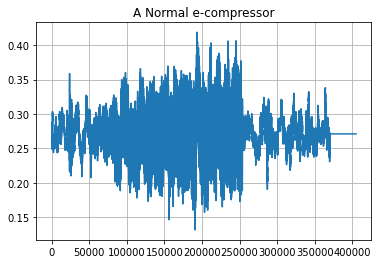

In [88]:
# 정상적인 ECG를 플롯합니다.
plt.grid()
plt.plot(normal_train_data[0])
plt.title("A Normal e-compressor")
plt.show()

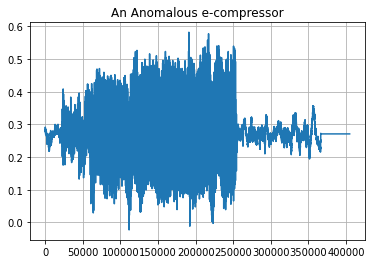

In [89]:
# 비정상적인 ECG를 플롯합니다.
plt.grid()
plt.plot(normal_test_nok[1])
plt.title("An Anomalous e-compressor")
plt.show()

In [90]:
# 모델 빌드하기
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(404853, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

autoencoder.compile(optimizer='adam', loss='mse')

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0531 - val_loss: 0.0532
Epoch 2/100
1/1 [==============================] - 0s 64ms/step - loss: 0.0531 - val_loss: 0.0531
Epoch 3/100
1/1 [==============================] - 0s 67ms/step - loss: 0.0531 - val_loss: 0.0531
Epoch 4/100
1/1 [==============================] - 0s 68ms/step - loss: 0.0531 - val_loss: 0.0529
Epoch 5/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0528 - val_loss: 0.0515
Epoch 6/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0514 - val_loss: 0.0455
Epoch 7/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0455 - val_loss: 0.0309
Epoch 8/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0308 - val_loss: 0.0114
Epoch 9/100
1/1 [==============================] - 0s 63ms/step - loss: 0.0114 - val_loss: 0.0063
Epoch 10/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0063 - val_loss: 0.0163
Epoch 11/100
1/1 [===

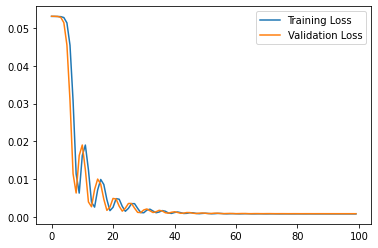

In [91]:
# autoencoder는 일반 ECG만 사용하여 훈련되지만, 전체 테스트세트를 사용하여 평가됩니다.
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=100, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

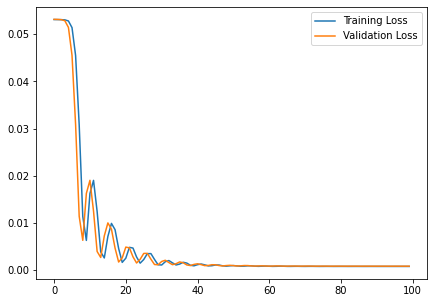

In [108]:
plt.figure(figsize = (7,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

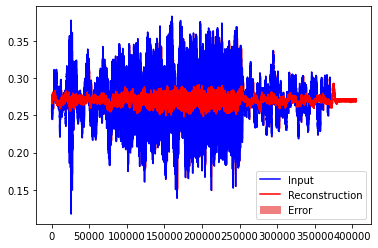

In [92]:
# 재구성 오류가 정상 훈련 예제에서 하나의 표준 편차보다 큰 경우, ECG를 비정상으로 분류합니다.
#  먼저, 훈련 세트의 정상 ECG, autoencoder에 의해 인코딩 및 디코딩된 후의 재구성, 재구성 오류를 플롯해 보겠습니다.
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(404853), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

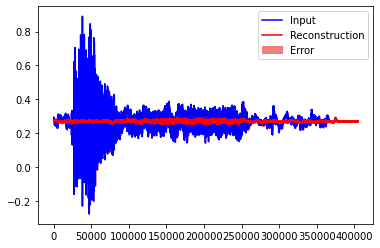

In [93]:
# 이번에는 비정상적인 테스트 예제에서 비슷한 플롯을 만듭니다.
encoded_data = autoencoder.encoder(normal_test_nok).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_nok[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(404853), decoded_data[0], normal_test_nok[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [94]:
# 이상 감지하기
# 재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상을 감지합니다.
#  이 튜토리얼에서는 훈련 세트에서 정상 예제에 대한 평균 오차를 계산한 다음,
#  재구성 오류가 훈련 세트의 표준 편차보다 큰 경우 향후 예제를 비정상적인 것으로 분류합니다.

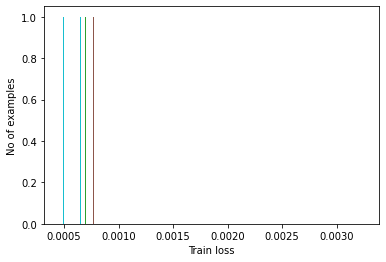

In [109]:
# 훈련 세트에서 정상 ECG에 대한 재구성 오류를 플롯합니다.

reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [111]:
print("mean of loss: ", np.mean(train_loss))
print("standard deviation of loss: ", np.std(train_loss))

mean of loss:  0.0007769476
standard deviation of loss:  0.00046364352


In [96]:
# 히스토그램 (Histogram)은 도수분포표를 그래프로 나타낸 것으로서, 가로축은 계급, 세로축은 도수 (횟수나 개수 등)를 나타냅니다.
# hist() 함수의 bins 파라미터는 히스토그램의 가로축 구간의 개수를 지정합니다

print(type(train_loss))
# <class 'tensorflow.python.framework.ops.EagerTensor'>
print(train_loss.shape)
(2359,)

print(type(train_loss[None,:]))
# <class 'tensorflow.python.framework.ops.EagerTensor'>
print(train_loss[None,:].shape)
# (1, 2359)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(34,)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 34)


In [97]:
print("train_loss mean: ", np.mean(train_loss))
print("train_loss std: ", np.std(train_loss))

train_loss mean:  0.0007769476
train_loss std:  0.00046364352


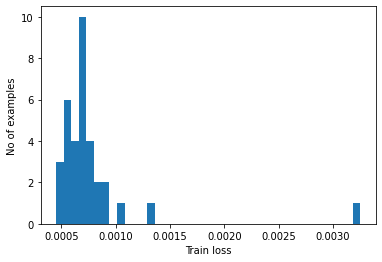

In [98]:
plt.hist(train_loss[None,:], bins=40)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [99]:
# 평균보다 표준 편차가 높은 임계값을 선택합니다.
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.001240591


In [100]:
# 참고: 테스트 예제를 이상 항목으로 분류하는 임계값을 선택하는 데 사용할 수 있는 다른 전략이 있습니다.
#  올바른 접근 방식은 데이터세트에 따라 다릅니다.
#  이 튜토리얼의 끝에 있는 링크를 통해 더 많은 것을 배울 수 있습니다.

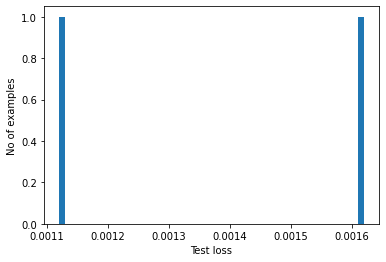

In [101]:
# 테스트 세트에서 비정상적인 예제에 대한 재구성 오류를 조사하면 대부분 임계값보다 더 큰 재구성 오류가 있음을 알 수 있습니다.
#  임계값을 변경하여 분류자의 정밀도와 재현율을 조정할 수 있습니다.
reconstructions = autoencoder.predict(normal_test_nok)
test_loss = tf.keras.losses.mse(reconstructions, normal_test_nok)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [102]:
# 재구성 오류가 임계값보다 큰 경우 ECG를 이상으로 분류합니다.
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mse(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 1.0
Precision = 1.0
Recall = 1.0
